# Определение возраста покупателей

## Описание данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:**

Построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Необходимо построить модель со значением метрики качества MAE не больше 8.

**План работ:**

- 1. Подготовка данных
    - Проведем исследовательский анализ набора фотографий
    - Подготовим данные к обучению.

- 2. Обучим нейронную сеть с архитектурой ResNET50 на подготовленных данных.
    
- 3. Проанализируем качество модели.
    
- 4. Сформулируем итоговый вывод.

## Исследовательский анализ данных

In [1]:
# ячейка для загрузки библиотек, служебных команд и функций
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.layers import  Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.simplefilter(action='ignore')

In [2]:
#считаем наши данные

pth_1 = '/datasets/faces/final_files/'  
pth_2 = '/datasets/faces/labels.csv'

labels = pd.read_csv(pth_2)

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=pth_1,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
print(f'Количество дубликатов: {labels.duplicated().sum()}')

Количество дубликатов: 0


In [7]:
print(f'Размер выборки: {labels.shape}')

Размер выборки: (7591, 2)


Имеем 7591 фотографию людей с меткой соответсвуюещего возраста от 1 года до 100 лет. Данные без пропусков и дубликатов, пригодны для проведения анализа. Выведем несколько фото с укзанием возраста для наглядности.

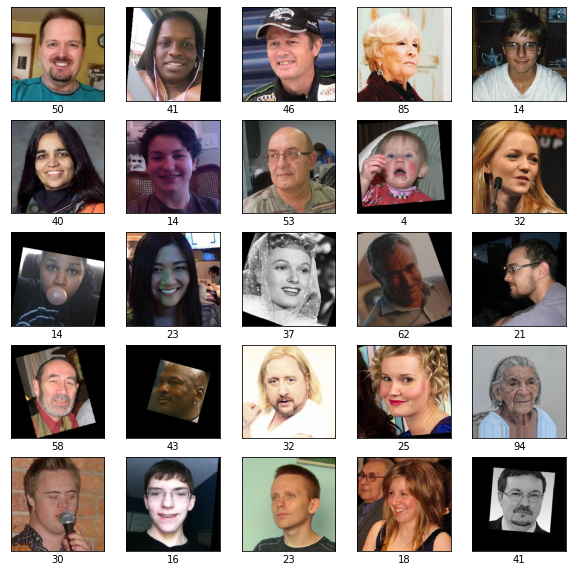

In [8]:
x, y  = train_datagen_flow.next()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

Прогнав несоклько батчей можно констатитровать, что не все фото одинакового качества: 
  - Присутсвуют черно-белые фото
  - C непонятной обрезкой
  - Разные уровни освещения
  - Закрытыми глазами и открытыми ртами
  - Фото в профиль и полуповернутые к объективу
  - Со смещением и повороротами по осям х и у.
  - Несколько человек в кадре
  - Люди с разрисованными лицами
  - В головных уборах и с очками
  
 И еще с десяток всяких прочих: на качелях, в огороде, с посторонними предметами, очень далеко от объектива. Попадались Николасы Кейджи, Билы Гейтсы и Квентины Тарантины.
 
Пока можно констатировать то, что мало бы кто с таким фото смог бы одобриться на грин-карту. Интересно как с определнием возраста по таким входным данным справятся наши модели.

Посмотрим, что со статистикой.

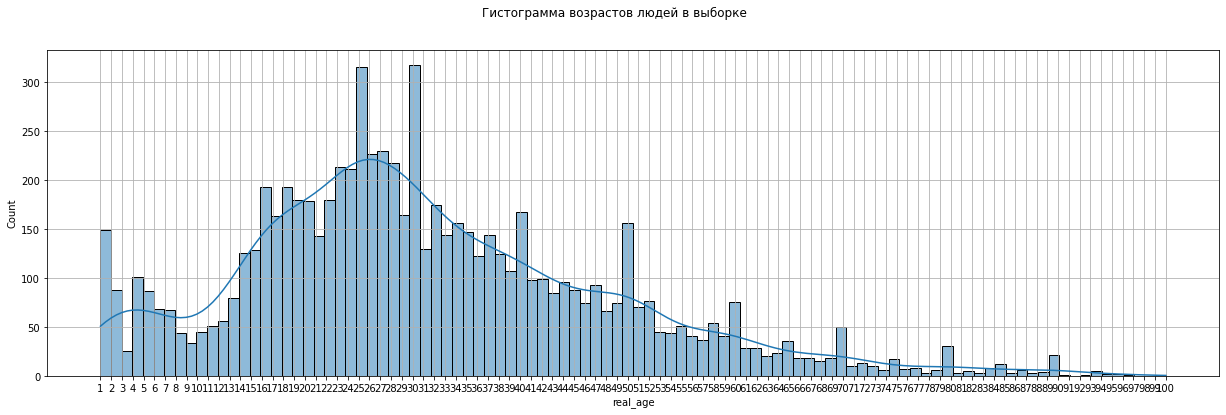

In [10]:
fig = plt.figure(figsize=(21, 6))
sns.histplot(data=labels.real_age, kde=True, bins=100)
plt.suptitle(f"Гистограмма возрастов людей в выборке")
plt.xticks(np.arange(1, 101, 1))
plt.grid(True)
plt.show()

Сильно скошенное влево рапсределение. Есть какие-то странные всплески на юбиленых датах? Результат округления? Посмотрим на размах.

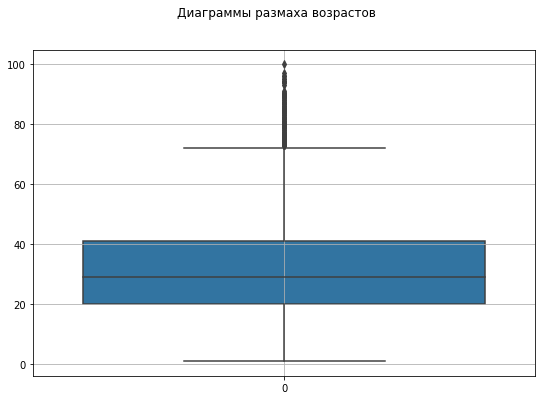

In [11]:
fig = plt.figure(figsize=(9, 6))
sns.boxplot(data=labels.real_age)
plt.suptitle("Диаграммы размаха возрастов")
plt.grid(True)
plt.show()

Даиграмма размаха считает, что все, что выше 70 это уже выбросы, а основная часть людей в выборке находится в возрастном промежутке от 20 до 40 лет

## Обучение модели

Обучение будем проводить на нейросети с архитектурой ResNET50.

```python
import numpy as np
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import  Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                 # vertical_flip=True,
                                 horizontal_flip=True,
                                 # rotation_range=90,
                                 # width_shift_range=0.3,
                                 # height_shift_range=0.3 пробовал разную аугментацию
                                 )
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-08-28 12:33:55.519950: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-28 12:33:55.807974: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 208.8578 - mae: 10.5317 - val_loss: 735.1270 - val_mae: 22.2047
Epoch 2/10
356/356 - 39s - loss: 85.7065 - mae: 7.0259 - val_loss: 173.7120 - val_mae: 9.7193
Epoch 3/10
356/356 - 39s - loss: 56.5653 - mae: 5.7604 - val_loss: 78.0962 - val_mae: 6.7598
Epoch 4/10
356/356 - 39s - loss: 45.0744 - mae: 5.1217 - val_loss: 78.6799 - val_mae: 6.7518
Epoch 5/10
356/356 - 39s - loss: 32.4504 - mae: 4.3684 - val_loss: 66.7217 - val_mae: 6.0615
Epoch 6/10
356/356 - 41s - loss: 26.1624 - mae: 3.8872 - val_loss: 84.3851 - val_mae: 6.9262
Epoch 7/10
356/356 - 44s - loss: 20.8035 - mae: 3.5031 - val_loss: 71.3101 - val_mae: 6.3670
Epoch 8/10
356/356 - 43s - loss: 16.1772 - mae: 3.0881 - val_loss: 76.5548 - val_mae: 6.7027
Epoch 9/10
356/356 - 43s - loss: 14.0569 - mae: 2.8531 - val_loss: 96.1443 - val_mae: 7.5869
Epoch 10/10
356/356 - 44s - loss: 13.1303 - mae: 2.7524 - val_loss: 66.5562 - val_mae: 6.0288
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 66.5562 - mae: 6.0288
Test MAE: 6.0288


```

## Анализ обученной модели

В представленных нам исходных данных содержалась 7591 фотография с отмеченным на ней возрастом. Фотографии были разного качества, так же был скос распределения возрастов в сторону среднего возраста 20-40 лет. Нам требовалось построить такую модель, которая может предсказывать возраст покупателей по фото с требуемой целевой метрикой MAE не выше 8.

Наша нейронная сеть, построенная на архитектуре ResNET, c применённой дополнительной аугментацией в виде горизонтального отображения дала результат MAE = 6, что полностью удовлетворяет предъявленным требованиям.

<p><u><b>Добавление V1</b></u></p>

Перед нами ставились две бизнес-задачи:
 - 1) Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
 
 
 Полученная метрика MAE=6 позволяет нам произвести категоризацию клиентов по возрастным группам. Так возрастные группы в большинстве своем разбиты на рамки в 10-15 лет. Например, дети 0-18, молодежь 19-35, средний возраст 36-55, пенсионеры 55+. Более точную градацию категорий возрастов должны устанавливать маркетологи и аналитики для конкретных групп товаров, но МАЕ=6 позволяет им это сделать с большой долей точности и репрезентативности.
 
 
 - 2) Контролировать добросовестность кассиров при продаже алкоголя.
 
 
 По законодательству нашей страны, при продаже алкоголя лицам не достигшим 18 лет, накладываются существенные штрафы как физическому лицу, то есть непосредственно продавцу, так и юридическому лицу - магазину. Определять возраст клиента при покупке алкоголя только при помощи этой нейросети конечно не стоит, потому что ответственность всегда на человеке, нейросеть не отштрафуешь. Именно поэтому у кассиров за кассой кроме жирной пометки: Пакет! Акционные товары! Всегда есть еще надпись "Паспорт и дата рождения ниже которой идут возраста, который на текущий момент старше 18 лет. И поэтому в некоторых спорных случаях спрашивают и у клиентов 30+. 
 
 Но проверять добросовестность продавцов избирательно конечно можно, просто категорезировать возраст покупателей до 30 лет и директору или старшему продавцу, или менеджеру выборочно проверять на записях камер, о том проверяют ли их продавцы паспорт у клиентов в группе "молодежь" при продаже алкоголя. Так можно выборочно проверять соблюдают ли сотрудники действующее законодательство РФ и внутреннние правила магазина.

✽✾✿❁❃❋❀